# Table of Content

<div id="toc" style="max-height: 415px; display: block;"><ol class="toc-item"><li><a href="#Task-3">Task 3</a><ol class="toc-item"><li><a href="#Text-pre-processing">Text pre-processing</a><ol class="toc-item"><li><a href="#Preprocess-data">Preprocess data</a></li><li><a href="#Text-preprocessing-pipeline">Text-preprocessing pipeline</a></li></ol></li><li><a href="#Topic-modeling">Topic modeling</a><ol class="toc-item"><li><a href="#Build-corpus">Build corpus</a></li><li><a href="#Train-LDA-model-with-different-numbers-of-topics">Train LDA model with different numbers of topics</a></li><li><a href="#Train-LDA-model-with-30-topics">Train LDA model with 30 topics</a></li></ol></li><li><a href="#Topic-visualisation">Topic visualisation</a></li><li><a href="#Conclusion">Conclusion</a></li></ol></li></ol></div>

# Task 3
> Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

In [1]:
import pandas as pd
import nltk
import pickle
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from nltk.stem import WordNetLemmatizer

%matplotlib inline
import matplotlib.pyplot as plt

/home/weizhang/.local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Text pre-processing

### Preprocess data

We start by loading the dataset and preprocessing its text field. We notice that both `ExtractedSubject` and `ExtractedBodyText` field contain much important information. So we decide to build our topic model on a combination of these two fields. We merge `ExtractBodyText` and `MetadataSubject` into a new column named `MergedText`.

In [2]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')

In [3]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [4]:
# return the concatenation of ExtractedSubject and ExtractedBodyText fields
def concat_text(x):
    return str(x.ExtractedSubject) + ' ' + str(x.ExtractedBodyText)

emails['MergedText'] = emails.apply(concat_text, axis=1)

In [5]:
emails['MergedText'][1]

'nan B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary'

### Text-preprocessing pipeline

We then perform a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) similar to task 1. 

1. <b>tokenlization</b>: we use <em>word_tokenize</em> method of nltk to generate tokens from texts.
2. <b>lowercase tokens</b>: we lowercase all tokens in order to merge the same words.
3. <b>remove tokens too short</b>: we remove tokens whose length <= 2, in order to improve accuracy and performance
4. <b>remove tokens without leading letters</b>: we remove tokens not started with a letter, to exclude punctuations and some meaningless tokens. Otherwise, topics generated are likely to have meaningless tokens. We only require the leading character of tokens to be alphabetic letters, instead of all characters to be alphabetic letters, because words like 'u.s.' do have non-alphabetic character '.' inside the word.
5. <b>remove stopwords</b>: we define our stop words by standard stop words and specific words common in emails.
6. <b>stemming</b>: we use PorterStemmer for stemming.

We define our stop words by standard stop words and specific words common in emails.

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
local_stop = {"re", "fw", "cc", "also", "pm", "am", "btw", "fyi", "to", "from"}
stop_words = stop_words | local_stop

We use PorterStemmer for stemming.

In [7]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [8]:
# preprocess a MergedText field
def preprocess(text):
    # 1. tokenlization
    tokens = nltk.word_tokenize(text)
    
    # 2. remove tokens whose length <= 2
    tokens_not_short = [t for t in tokens if len(t) > 2]

    # 3. lowercase tokens
    tokens_lowercased = [t.lower() for t in tokens_not_short]
    
    # 4. remove tokens without a leading letter
    tokens_started_with_letter = [t for t in tokens_lowercased if t[0].isalpha()] 

    # 5. remove stop words 
    tokens_without_stop_words = [t for t in tokens_started_with_letter if t not in stop_words]
    
    # 6. stemming
    stemmed_tokens = [ps.stem(t) for t in tokens_without_stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in stemmed_tokens]
    
    return lemmatized_tokens

In [9]:
texts = [ preprocess(text) for text in emails.MergedText]

## Topic modeling

### Build corpus

We construct a dictionary which map every token to a unique ID.

In [10]:
dictionary = corpora.Dictionary(texts)

We build corpus according to the directionay.

In [11]:
corpus = [dictionary.doc2bow(text) for text in texts]

### Train LDA model with different numbers of topics

Then, let's train the LDA model with different numbers of topics. We tried 5, 15, 30, 50 as number of topics. We split blocks to deal with different number of topics instead of doing it in a loop, because model.print_topics() does not work well inside a loop for some reason. 

We set the number of iterations to 10.

In [12]:
N_PASSES = 10

We start by trying 5 topics.

In [13]:
N_TOPICS = 5
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)
model.print_topics()

[(0,
  '0.010*"state" + 0.007*"u.s." + 0.007*"israel" + 0.006*"secur" + 0.005*"govern" + 0.004*"afghanistan" + 0.004*"obama" + 0.004*"new" + 0.004*"presid" + 0.004*"would"'),
 (1,
  '0.006*"would" + 0.006*"said" + 0.005*"n\'t" + 0.005*"one" + 0.005*"obama" + 0.005*"presid" + 0.005*"year" + 0.004*"peopl" + 0.004*"time" + 0.004*"new"'),
 (2,
  '0.007*"koch" + 0.005*"obama" + 0.005*"group" + 0.005*"n\'t" + 0.005*"tea" + 0.004*"parti" + 0.004*"beck" + 0.004*"book" + 0.004*"jewish" + 0.003*"movement"'),
 (3,
  '0.044*"nan" + 0.026*"call" + 0.009*"talk" + 0.008*"state.gov" + 0.008*"see" + 0.008*"get" + 0.008*"tomorrow" + 0.007*"work" + 0.007*"want" + 0.007*"thank"'),
 (4,
  '0.040*"secretari" + 0.033*"offic" + 0.033*"depart" + 0.030*"state" + 0.019*"meet" + 0.017*"room" + 0.013*"arriv" + 0.012*"rout" + 0.010*"hous" + 0.010*"privat"')]

As we can see, topics generated contain many generic words, like 'one', 'said', etc. These general words are trivial and give limited information.

Let's move on to try 15 topics.

In [14]:
N_TOPICS = 15
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)
model.print_topics()

[(0,
  '0.189*"nan" + 0.024*"thank" + 0.019*"reuter" + 0.012*"best" + 0.010*"wjc" + 0.008*"happi" + 0.006*"talk" + 0.006*"year" + 0.006*"meet" + 0.006*"updat"'),
 (1,
  '0.013*"obama" + 0.011*"republican" + 0.010*"democrat" + 0.010*"presid" + 0.009*"senat" + 0.009*"said" + 0.008*"vote" + 0.008*"hous" + 0.007*"would" + 0.007*"n\'t"'),
 (2,
  '0.048*"call" + 0.015*"talk" + 0.014*"want" + 0.013*"get" + 0.011*"back" + 0.010*"tri" + 0.010*"ask" + 0.010*"today" + 0.009*"n\'t" + 0.009*"time"'),
 (3,
  '0.011*"state" + 0.009*"work" + 0.009*"develop" + 0.008*"secur" + 0.008*"u.s." + 0.007*"need" + 0.007*"govern" + 0.007*"woman" + 0.007*"nation" + 0.007*"effort"'),
 (4,
  '0.044*"call" + 0.023*"schedul" + 0.018*"list" + 0.012*"ye" + 0.011*"secretari" + 0.009*"branch" + 0.009*"lona" + 0.009*"pl" + 0.008*"assist" + 0.008*"add"'),
 (5,
  '0.011*"good" + 0.011*"ireland" + 0.011*"northern" + 0.010*"get" + 0.009*"see" + 0.007*"uup" + 0.007*"deal" + 0.007*"great" + 0.006*"sent" + 0.006*"articl"'),
 (6,

The result still contains many generic words.

How about 30 topics?

In [15]:
N_TOPICS = 30
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)
model.print_topics()

[(3,
  '0.070*"secretari" + 0.066*"offic" + 0.051*"depart" + 0.040*"meet" + 0.034*"room" + 0.027*"state" + 0.025*"arriv" + 0.022*"rout" + 0.020*"privat" + 0.019*"confer"'),
 (26,
  '0.022*"republican" + 0.020*"senat" + 0.019*"democrat" + 0.013*"hous" + 0.012*"bill" + 0.011*"vote" + 0.011*"said" + 0.010*"percent" + 0.010*"obama" + 0.009*"would"'),
 (6,
  '0.046*"woman" + 0.018*"right" + 0.015*"haiti" + 0.015*"health" + 0.014*"human" + 0.014*"child" + 0.013*"food" + 0.011*"develop" + 0.011*"foundat" + 0.010*"global"'),
 (4,
  '0.054*"state" + 0.033*"benghazi" + 0.033*"inform" + 0.033*"case" + 0.031*"hous" + 0.029*"subject" + 0.029*"date" + 0.028*"u.s." + 0.027*"depart" + 0.024*"sensit"'),
 (27,
  '0.042*"china" + 0.017*"chine" + 0.012*"polici" + 0.009*"deal" + 0.009*"econom" + 0.008*"asia" + 0.008*"new" + 0.007*"interest" + 0.007*"good" + 0.007*"develop"'),
 (19,
  '0.059*"huma" + 0.040*"abedin" + 0.037*"nan" + 0.034*"state.gov" + 0.021*"wjc" + 0.016*"hrc" + 0.016*"abedinh" + 0.014*"wrot

Words in topics are much more specific now!

How about 50 topics?

In [16]:
N_TOPICS = 50
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)
model.print_topics()

[(40,
  '0.085*"thank" + 0.057*"sid" + 0.032*"memo" + 0.030*"hillari" + 0.029*"new" + 0.023*"best" + 0.020*"hope" + 0.019*"happi" + 0.019*"year" + 0.019*"home"'),
 (16,
  '0.114*"call" + 0.042*"talk" + 0.040*"tomorrow" + 0.020*"back" + 0.019*"work" + 0.018*"get" + 0.018*"ask" + 0.014*"want" + 0.014*"tri" + 0.013*"holbrook"'),
 (22,
  '0.038*"parti" + 0.024*"ireland" + 0.023*"tea" + 0.016*"uup" + 0.015*"deal" + 0.014*"polic" + 0.013*"dup" + 0.013*"justic" + 0.012*"unionist" + 0.012*"polit"'),
 (0,
  '0.014*"state" + 0.011*"world" + 0.011*"china" + 0.011*"unit" + 0.010*"peopl" + 0.009*"govern" + 0.009*"american" + 0.009*"countri" + 0.006*"presid" + 0.005*"attack"'),
 (1,
  '0.395*"nan" + 0.062*"cheryl" + 0.050*"state.gov" + 0.045*"mill" + 0.034*"sullivan" + 0.027*"jacob" + 0.023*"millscd" + 0.016*"friday" + 0.014*"thursday" + 0.013*"april"'),
 (44,
  '0.122*"ye" + 0.062*"bill" + 0.057*"iran" + 0.039*"burn" + 0.027*"urgent" + 0.027*"question" + 0.023*"john" + 0.019*"kerri" + 0.016*"recomm

### Train LDA model with 30 topics

After the exploration of different numbers of topics, we think the best fit is 30 topics. From now on, we focus on the model with 30 topics. We increase the number of iterations from 20 to 50, and train the LDA model again.

In [17]:
N_TOPICS = 30
N_PASSES = 30
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)
model.print_topics()

[(7,
  '0.030*"ireland" + 0.028*"minist" + 0.020*"uup" + 0.018*"robinson" + 0.016*"dup" + 0.015*"unionist" + 0.015*"justic" + 0.013*"deliv" + 0.011*"agreement" + 0.009*"devolut"'),
 (20,
  '0.060*"state" + 0.036*"benghazi" + 0.033*"inform" + 0.032*"u.s." + 0.032*"subject" + 0.031*"hous" + 0.030*"case" + 0.028*"depart" + 0.027*"date" + 0.027*"agreement"'),
 (25,
  '0.008*"state" + 0.006*"govern" + 0.006*"one" + 0.006*"would" + 0.005*"peopl" + 0.005*"nation" + 0.005*"work" + 0.005*"new" + 0.004*"american" + 0.004*"year"'),
 (6,
  '0.021*"holbrook" + 0.017*"week" + 0.017*"see" + 0.012*"korea" + 0.012*"wjc" + 0.011*"note" + 0.011*"north" + 0.011*"last" + 0.011*"dinner" + 0.010*"night"'),
 (16,
  '0.039*"thank" + 0.034*"speech" + 0.022*"draft" + 0.020*"print" + 0.018*"work" + 0.017*"hope" + 0.016*"thx" + 0.016*"get" + 0.016*"pl" + 0.015*"great"'),
 (29,
  '0.013*"boehner" + 0.011*"haiti" + 0.010*"aid" + 0.009*"u.s." + 0.009*"dollar" + 0.009*"fund" + 0.008*"million" + 0.008*"econom" + 0.008*

## Topic visualisation

The result of every topic contains both words and their scores, making it hard to read. Thus, we build a WordCloud for every topic in order to show them more clearly. 

In [18]:
from wordcloud import WordCloud

In [19]:
def plot_wordcloud(word_freq_tuples):
    plt.figure()
    plt.imshow(WordCloud(max_font_size=40).fit_words(word_freq_tuples))
    plt.axis("off")
    plt.show()

In [20]:
def visualise_topics(topics):
    for topic in topics:
        word_freq_tuples = topic[1]
        topic_idx = topic[0]
        print('topic ' + str(topic_idx) + ':')
        plot_wordcloud(word_freq_tuples)#word_freq_tuples)

In [21]:
N_WORDS = 30
topics = model.show_topics(num_topics=N_TOPICS, num_words=N_WORDS, formatted=False)

topic 0:


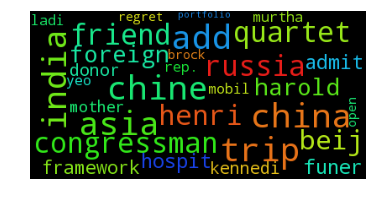

topic 1:


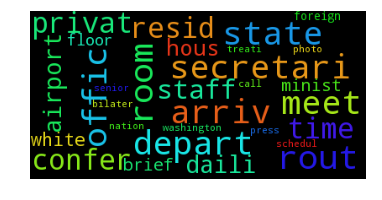

topic 2:


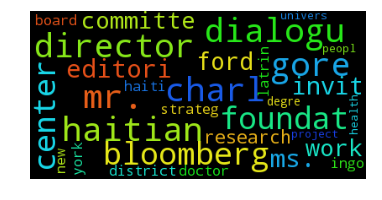

topic 3:


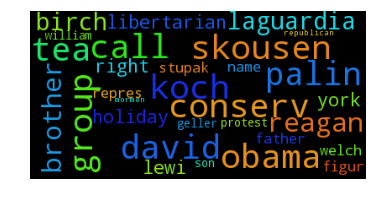

topic 4:


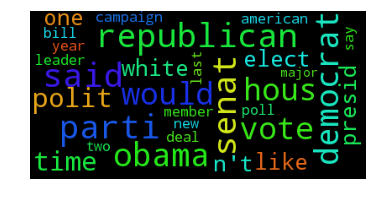

topic 5:


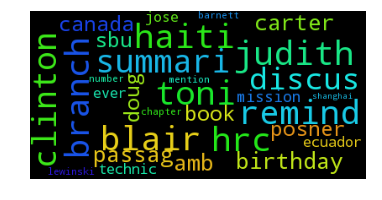

topic 6:


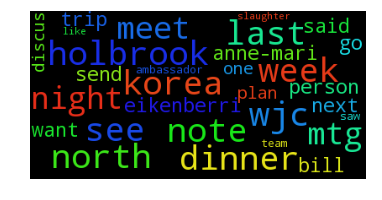

topic 7:


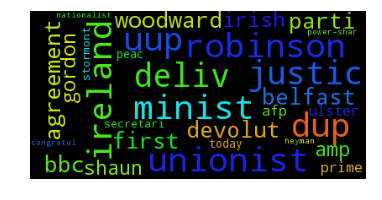

topic 8:


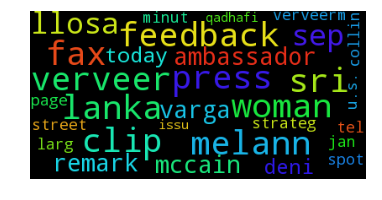

topic 9:


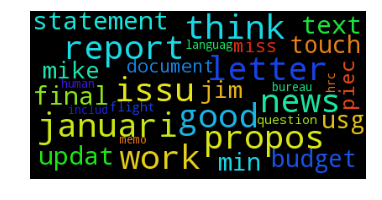

topic 10:


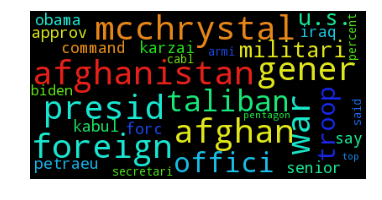

topic 11:


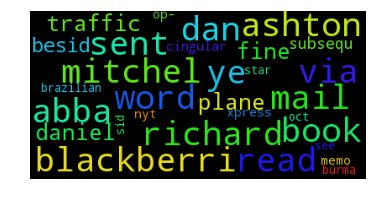

topic 12:


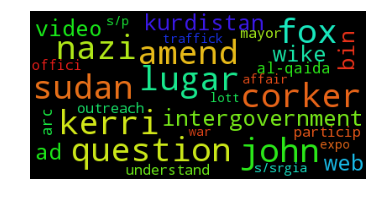

topic 13:


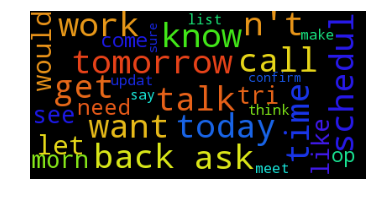

topic 14:


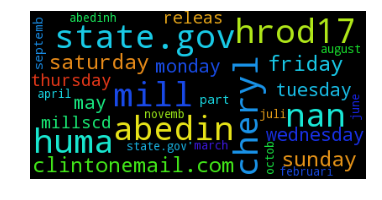

topic 15:


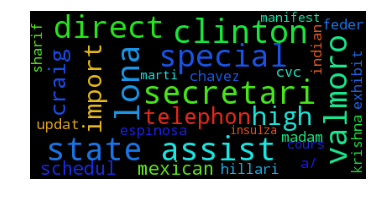

topic 16:


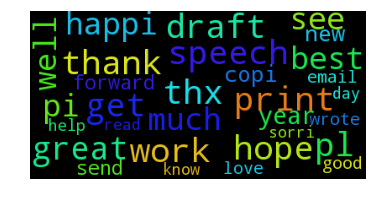

topic 17:


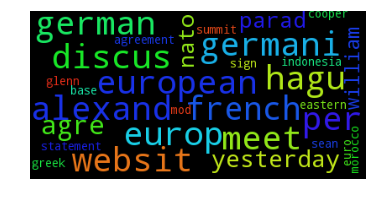

topic 18:


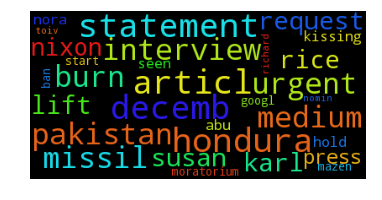

topic 19:


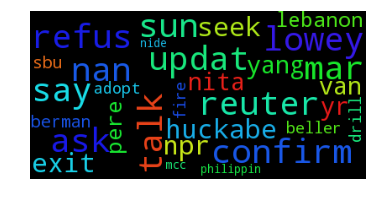

topic 20:


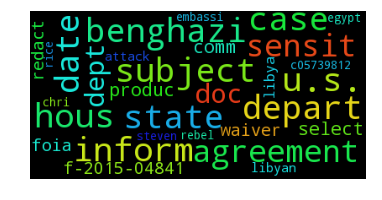

topic 21:


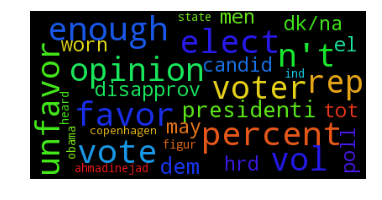

topic 22:


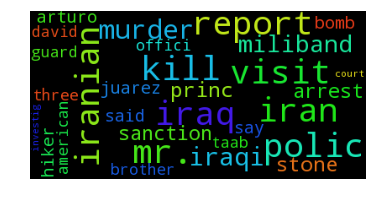

topic 23:


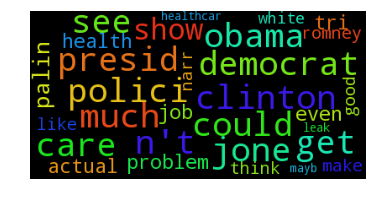

topic 24:


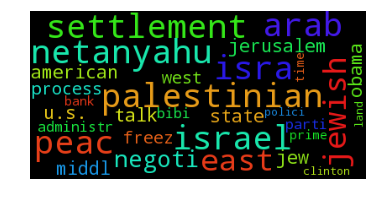

topic 25:


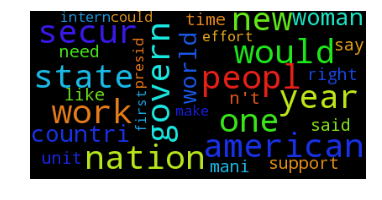

topic 26:


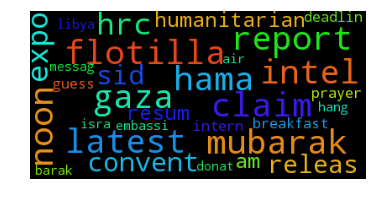

topic 27:


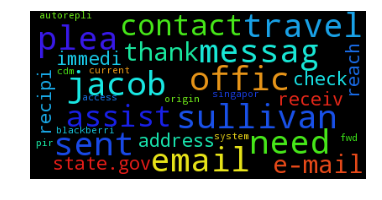

topic 28:


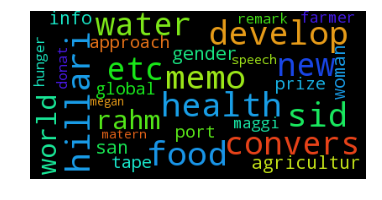

topic 29:


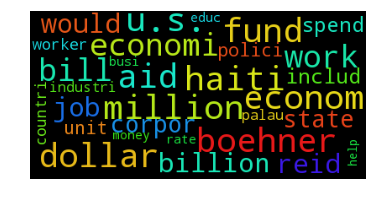

In [22]:
visualise_topics(topics)

We can obtain much information from the topics generated above. For example, Topic 0 talks about china and russia. Topic 2 probably discusses the arrival and departure of privated secretaries. 

## Conclusion

Topic model is quite powerful. Large amount of texts is hard to read and understand. Generating topics with LDA topic model helps understand texts a lot!